## Carbon-I Testbed Prototype

A prototype instrument has already been developed at JPL to demonstrate the Carbon-I measurement concept. This **testbed** incorporates a Dyson block, grating, and focal-plane array (FPA) matching Carbon-I’s anticipated optical design and performance specifications. Through laboratory measurements, the testbed can validate key elements such as **spectral resolution**, **imaging fidelity**, **throughput**, and **straylight** characteristics. These  demonstrations can confirm that Carbon-I’s architecture is both **technically feasible** and **robust**, ensuring confidence as we proceed toward a flight-ready instrument. 

In its current setup, the **testbed spectra** are measured under a **warm environment**, so the system is not fully aligned at flight operating temperatures. Consequently, the **spectral response function (SRF)** in these early demonstrations will appear more **fuzzy** than what we expect under cold, flight-like alignment conditions—a refinement that will be investigated in subsequent testbed campaigns.

---

Below, we walk through the **testbed-spectra fitting** procedure using measurements from a **light source** paired with a **CH<sub>4</sub> gas cell**. All examples here leverage the **Julia** programming language, chosen for its **high-level syntax** and **near-C speed**, making it ideally suited for the **Carbon-I** data processing pipeline. 

> First, we need to import some packages in Julia

In [71]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM
# Using standard Julia packages for Linear albegra, Differentiation, etc.
using SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults
# Using the Makie package for plotting
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))

  Activating project at `~/code/gitHub/CarbonI`


pwd()

> Reading in the testbed spectra, stored as simple CSV file:

In [38]:
testbed_ch4 = readdlm("../../data/20250131 CITB CH4.csv",',');
testbed_ch4_cold = readdlm("../../data/CITB/20250317-CITB-Methane.csv",',');
testbed_co_cold = readdlm("../../data/CITB/20250317-CITB-CO.csv",',');

In [39]:
testbed_ch4_cold[:,1]

512-element Vector{Float64}:
 2034.7
 2035.4
 2036.1
 2036.8
 2037.5
 2038.2
 2038.9
 2039.6
 2040.3
 2041.0
    ⋮
 2386.8
 2387.5
 2388.2
 2388.9
 2389.6
 2390.3
 2391.0
 2391.7
 2392.4

> Loading Methane Spectroscopy from a pre-computed cross section table (tools included in vSmartMOM) and then computing the cross section of CH<sub>4</sub>  at the temperature and pressure in the laboratory (WAGs)

In [40]:
# Load Cross section database
ch4 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/ch4_model.jld2")
co = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/co_model.jld2")
# Generate cross section at TestBed condition
p = 940.0 # Pressure in hPa
T = 295.0 # Temperature in K
Δwl = 0.005 # Resolution in nm
# Define high resolution wavelength grid (needs to be larger than the Carbon-I wavelength range to account for the SRF impact at the edges)
wl_grid_hr = 2030:Δwl:2398
xs_ch4  = reverse(vSmartMOM.absorption_cross_section(ch4, wl_grid_hr, p, T; wavelength_flag=true));
xs_co  = reverse(vSmartMOM.absorption_cross_section(co, wl_grid_hr, p, T; wavelength_flag=true)); # Has to be reversed to match the order of the data (as table is in wavenumber)


> Define an Instrument function (using tools developed in Carbon-I), modeling the Spectral Response Function as a mix of two boxcar functions (for slit and detector pixel) as well as a Gaussian (for optical effects)

In [41]:
# Define an instrument (Convolution of 2 Box kernels with a Gaussian):
FWHM  = 0.65  # Full Width at Half Maximum in nm 
SSI  = 0.7   # Spectral Sampling Interval in nm
# Define the kernels:
# Spectral response function of the slit (2*SSI)
kern1 = CarbonI.box_kernel(1.6*SSI, Δwl)
# Spectral response function of the optics (Gaussian)
kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
# Spectral response function of the pixel (1*SSI)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the instrument (stores convolution kernel and wavelength grid):
CarbonI_SRF = CarbonI.KernelInstrument(kernf, collect(2036.7:SSI:2394.4));

> Model Transmission with a first guess of the vertical column density in the cell (8e19molec/cm2 here, which is roughly a double-pass through the atmosphere).

In [42]:
vcd = 0.8e20 # molec/cm²
# Transmission of entire cell:
T_CH4 = exp.(-xs_ch4*vcd)
# Transmission of instrument:
T_CH4_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CH4);

> Plot the **unfitted** modeled and measured spectra as well as the high resolution transmission computed before convolution to the Carbon-I grid

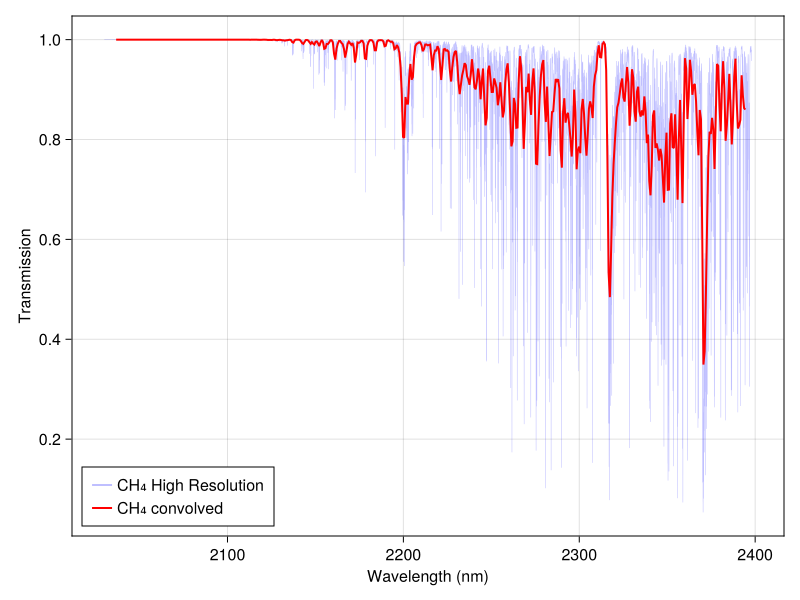

In [43]:
f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
lines!(ax, wl_grid_hr, T_CH4, color = :blue, linewidth = 0.5, alpha=0.25, label = "CH₄ High Resolution")
lines!(ax, CarbonI_SRF.ν_out, T_CH4_conv, color = :red, linewidth = 2.0, label = "CH₄ convolved")
#lines!(ax, testbed_ch4[:,1], testbed_ch4[:,2]./maximum(testbed_ch4[:,2]), color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(position = :lb)
f

### Setting up a spectral fit

---

Now comes one of the most important parts of our fitting routine: **establishing a simple forward model** for the testbed spectra. Below is an example function in **Julia** that takes in a state vector containing parameters like wavelength offset, vertical column density, and instrument SRF specifications, and returns the modeled transmission curve. This function references **CH₄ cross sections**, applies **kernels** to simulate Carbon-I’s instrument resolution, and multiplies the resulting convolved spectrum by a **baseline polynomial** term to account for broad-band absorption structures that might come from the gas cell windows (similar to how surface albedo variationscan vary the broad-band variations in observed spectra when measured from space).

---

First, we define a simple forward model F(x) that maps our state vector x to modeled measurements.  x includes spectral calibration, vertical column density of the target gas, FWHM of the SRF, polynomial for broad band features.

In [44]:
# Set up a simple forward model to fit the data
function forward_model_testbed(x::AbstractArray{FT} ;xs = xs, wl_grid_hr = wl_grid_hr, Δwl=Δwl, ind=ind) where {FT}
    ############# Extract the parameters of the state vector: ################  
    # Start Wavelength
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    # Fixed grid subset for now:
    # ind = 50:500
    # Compute Carbon-I grid as 2nd order polynomial of the index
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    # Vertical Column density (in molec/cm2):
    vcd = x[4]
    # FWHM (Full Width at Half Maximum)
    FWHM = x[5]
    # Poynomial terms
    poly = Legendre(x[6:end])

    ############# Start of the forward model ################################  
    # Compute total optical thickness (cross section * vertical column density)
    τ = xs * vcd
    # Compute Transmission
    T = exp.(-τ)
    #@show T
    # Define the instrument SRF:
    #SSI  = 0.7
    # Kernel 1 simulates slit width as boxcar:
    kern1 = CarbonI.box_kernel(1.8SSI, Δwl)
    # Gaussian kernel simulates the resolution of the instrument:
    kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
    # Kernel 3 reresents the pixel itself (1*SSI boxcar)
    kern3 = CarbonI.box_kernel(SSI, Δwl)
    # Combine the kernels, basically a multiplication of their Fourier Transforms:
    kernf = imfilter(imfilter(kern1, kern2), kern3)
    # Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
    CarbonI_SRF = CarbonI.KernelInstrument(kernf, carbonI_wlGrid);
    
    # Convolve with instrument function
    T_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T)
    x_poly = CarbonI.rescale_x(CarbonI_SRF.ν_out)
    # Multiply Convolved transmission with the baseline polynomial
    return T_conv .* poly.(x_poly)
end

# Just a simple function to compute the grid from the state vector outside of the forward model (lazy)
function getGrid(x; ind=ind)
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    return carbonI_wlGrid
end

getGrid (generic function with 1 method)

> Now we can define a **prior** state vector and run the forward model. Note that this is **not optimized** but just evaluation the forward model at our first guess

In [45]:
x = [2033.1, 0.7, 0,  3.8e20, 1.2,  1.0, 0.0e-10, 0.0e-10, 0.0e-10, 0.0e-10,0.0e-10, 0.0e-10, 0.0e-10,0.0e-10,0.0e-10, 0.0e-10,0.0e-10];
ind = 101:500
yy = forward_model_testbed(x);
wl_grid = getGrid(x);

# Set Gas to CH4:
# Switch CH4 to CO:
xs = xs_ch4;

> Now we just plot it overlay the measured spectrum. It looks pretty good but is of course not yet **optimized**, i.e. we aim to minimize the squared residuals of (y-F(x))

In [72]:

function plotFit()
    f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid, yy, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
    lines!(ax, testbed_ch4_cold[ind.+2,1], testbed_ch4_cold[ind,2]./maximum(testbed_ch4_cold[ind,2]), color = :gray, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    axislegend(position = :lb)
    f
end

plotFit (generic function with 1 method)

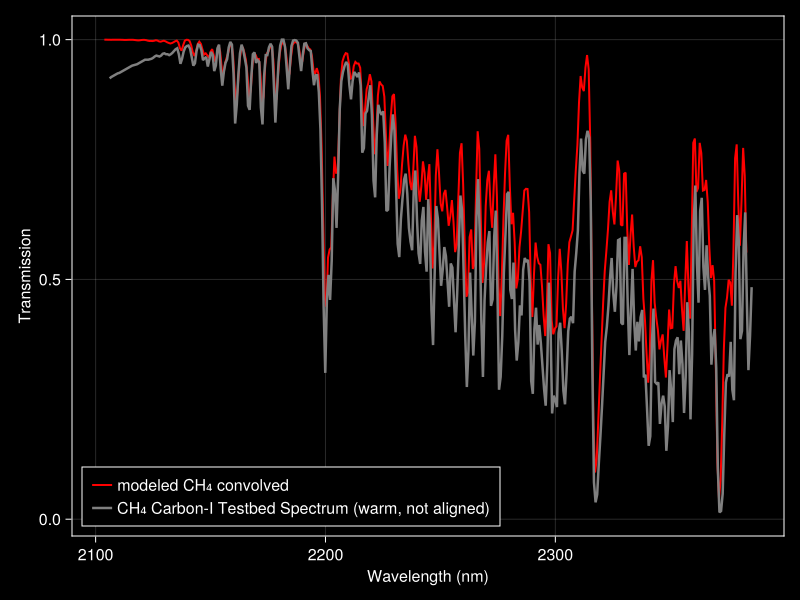

In [73]:
with_theme(plotFit, theme_black())

> Now we can set up an actual first defining the prior and error covariance matrices (a bit overkill for this application but is provides flexibility)

In [116]:
# Define the detector indices to include in the fit:
ind = 101:500

# Number of iterations:
n_iter = 8
# Initiate 2D array to store the state vector at each iteration
x_all = zeros(length(x),n_iter+1);
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_ch4_cold[:,2]./maximum(testbed_ch4_cold[:,2]);
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.-3];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
# Set first guess as the first column of the state vector array
x_all[:,1] .= x;
# Set Pior state vector to what we used before (which is far enough from the true solution)
xa = x;

# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.005*y).^2);
# Define prior covariance matrix (see CSR Box). 
Sa = zeros(length(x),length(x));
Sa[1,1] = 0.2^2; # For the start wavelength
Sa[2,2] = 0.05^2; # For the SSI
Sa[3,3] = 0.000002^2; # For the SSI square
Sa[4,4] = 5e20^2; # For the CH4 VCD
Sa[5,5] = 0.5^2;  # For the FWHM (in nm)

# For polynomial terms *basically unconstrained)
for i=6:length(x)
    Sa[i,i] = 1^2;
end

In [ ]:
# run iterations
xs = xs_ch4
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end
x_fit_cold = x_all[:,end];


17-element Vector{Float64}:
 2033.1142340003528
    0.7039017631195025
   -9.52747256694171e-6
    5.170645779534038e20
    0.6404815433348579
    0.9124528093621783
   -0.11687112281172009
   -0.039682456827756826
    0.07615947506248683
   -0.022366533374758857
   -0.033982798288888644
    0.003207019235426427
    0.020773359198654667
   -0.003935847951947194
   -0.014805251472534364
   -0.0009703132638676296
    0.0017247998586288876

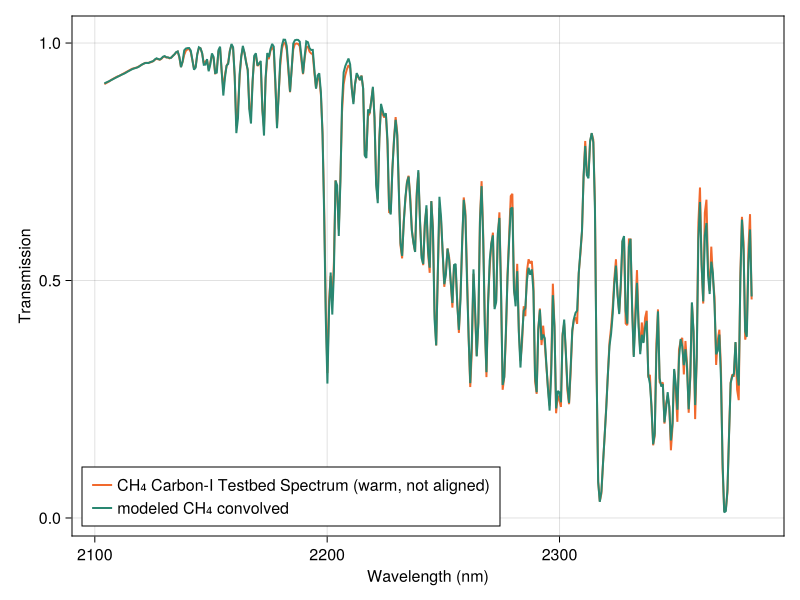

In [118]:
F_cold = forward_model_testbed(x_fit_cold);
wl_grid = getGrid(x_fit_cold);
f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid, y, color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    lines!(ax, wl_grid, F_cold, color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
    axislegend(position = :lb)
f

> Now we can run the iterative fit (arbitray cutoff here) and save all results per iteration

In [119]:
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y_warm = testbed_ch4[:,2]./maximum(testbed_ch4[:,2]);
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y_warm = y_warm[ind.+1];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
#x[6] = maximum(y_warm)
x_all[1,1] = 2036.7;
xs = xs_ch4
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y_warm - F + K *(x_all[:,i]-xa));
end
x_fit_warm = x_all[:,end];
F_warm = forward_model_testbed(x_fit_warm);
wl_warm = getGrid(x_fit_warm);

In [192]:
# Kernel 1 simulates slit width as boxcar:
kern1 = CarbonI.box_kernel(2SSI, Δwl)
# Gaussian kernel simulates the resolution of the instrument:
kern2 = CarbonI.gaussian_kernel(x_fit_warm[5]  , Δwl)
# Kernel 3 reresents the pixel itself (1*SSI boxcar)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels, basically a multiplication of their Fourier Transforms:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_warm = CarbonI.KernelInstrument(kernf, wl_warm);
kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_cold = CarbonI.KernelInstrument(kernf, wl_grid);

function plotFitBoth()
    f = Figure(resolution = (800, 600))
        ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission (offset for clarity)", title="CH₄ Testbed Spectrum (cold and warm)")
        lines!(ax, wl_warm, F_warm .+0.2, color = CarbonI_colors[3], linewidth = 2, label = "modeled CH₄ convolved")
        lines!(ax, wl_warm, y_warm .+0.2, color = CarbonI_colors[5], linewidth = 2, label = "CH₄ Testbed Spectrum (warm, initial alignment)")
        
        lines!(ax, wl_grid, F_cold, color = CarbonI_colors[3], linewidth = 2)
        lines!(ax, wl_grid, y, color = CarbonI_colors[4], linewidth = 2, label = "CH₄ Testbed Spectrum (cold aligned)")
        
        ax_inset = Axis(f[1, 1],xlabel = "Δwl (nm)", ylabel = "Normalized Response",#backgroundcolor = :white,
        width=Relative(0.2),
        height=Relative(0.2),
        halign=0.1,
        valign=0.35,
        title="Fitted SRF")
        lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent), color = CarbonI_colors[4], linewidth = 2, label = "Cold Aligned")
        lines!(ax_inset, Δwl .*(-1400:1400),CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent), color = CarbonI_colors[5], linewidth = 2, label = "Warm (initital) Aligned")
        xlims!(ax_inset, -4, 4)
        lines!(ax_inset, [-1.25, 1.25], [0.5, 0.5], color = :black, linewidth = 2)
        lines!(ax_inset, [-0.8, 0.8], [0.5, 0.5], color = :red, linewidth = 2.)
        axislegend(ax,position = :lb)
        xlims!(ax,2110, 2380)
    f
end

plotFitBoth (generic function with 1 method)

In [182]:
CarbonI_SRF_cold.kernel

2801-element OffsetArray(::Vector{Float64}, -1400:1400) with eltype Float64 with indices -1400:1400:
 -1.7585392650969947e-19
 -3.5170785301939894e-19
 -5.547664766362543e-19
 -2.0305862361685533e-19
  0.0
 -1.7585392650969947e-19
 -3.789125501265548e-19
 -5.547664766362543e-19
  0.0
  0.0
  ⋮
 -3.1331733688842955e-19
 -1.9419201457401887e-19
  5.826897085211537e-20
 -1.0988900507976356e-21
 -1.6855392795355636e-19
  1.9568024037848773e-19
 -1.9346366643008863e-19
 -6.086285077110347e-20
 -1.987514359706184e-19

off = -1541
fwhm = -1.56
fwhm = -1.95


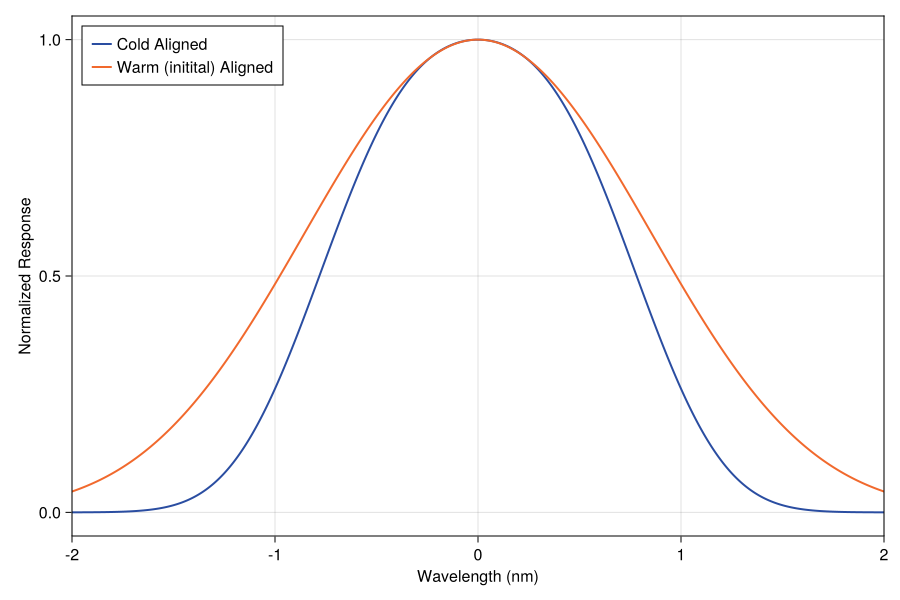

In [ ]:
#plot(CarbonI_SRF_cold.ν_out, CarbonI_SRF_cold.kernel, color = :red, linewidth = 2, label = "Cold")

# Kernel 1 simulates slit width as boxcar:
kern1 = CarbonI.box_kernel(2.SSI, Δwl)
# Gaussian kernel simulates the resolution of the instrument:
kern2 = CarbonI.gaussian_kernel(1.5  , Δwl)
# Kernel 3 reresents the pixel itself (1*SSI boxcar)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels, basically a multiplication of their Fourier Transforms:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_warm = CarbonI.KernelInstrument(kernf, wl_warm);
kern2 = CarbonI.gaussian_kernel(x_fit_cold[5]  , Δwl)
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
CarbonI_SRF_cold = CarbonI.KernelInstrument(kernf, wl_grid);

off = CarbonI_SRF_cold.kernel.offsets[1]
@show off
xx = off+1:-off-1
f = Figure(resolution = (900, 600))
        ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Normalized Response")
        lines!(ax, Δwl .* xx,CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent), color = CarbonI_colors[4], linewidth = 2, label = "Cold Aligned")
        lines!(ax, Δwl .* xx,CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent), color = CarbonI_colors[5], linewidth = 2, label = "Warm (initital) Aligned")

        axislegend(position = :lt)
        xlims!(-2, 2)
    f

find_fwhm = argmin(abs.(CarbonI_SRF_cold.kernel.parent./maximum(CarbonI_SRF_cold.kernel.parent) .-0.5));
fwhm = 2*(find_fwhm+off)*Δwl
@show fwhm
find_fwhm = argmin(abs.(CarbonI_SRF_warm.kernel.parent./maximum(CarbonI_SRF_warm.kernel.parent) .-0.5));
fwhm = 2*(find_fwhm+off)*Δwl
@show fwhm
f

In [229]:
x_fit_warm[5]
x_fit_cold[5]

0.6404815433348579

In [213]:
CarbonI_SRF_cold.kernel.offsets[1]

-1401

In [ ]:
CarbonI_SRF_cold.kernel.offset

(-1261,)

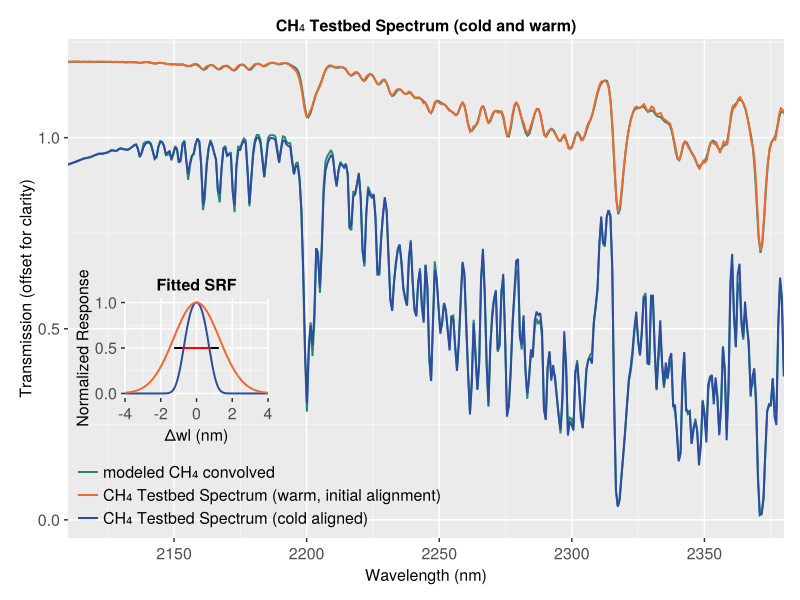

In [194]:
ff = with_theme(plotFitBoth, theme_ggplot2())
save( "../../plots/CH4_Cold_Warm_Aligned.pdf", ff)
ff

> Extract the best fit (last iteration)

In [53]:
y_fit = forward_model_testbed(x_all[:,end]);

> Plot the best fit over the entire wavelength range (note, we didn't model a wavelength dependence of the SRF yet)

In [ ]:
function plotFit()
    f = Figure(resolution = (800, 600))
    ii = ind .+1 
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
    lines!(ax,  getGrid(x_all[:,end]), y_fit, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
    #lines!(ax, CarbonI_SRF.ν_out, forward_model_testbed(x), color = :green, linewidth = 2.0, label = "prior CH₄ convolved")
    lines!(ax, getGrid(x_all[:,end]), y, color = :orange, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (cold aligned)")
    axislegend(ax,position = :lb)
    lines!(ax2, getGrid(x_all[:,end]), (y_fit.-y)*100, color = :orange, linewidth = 2.5, label = "Fit Residual")
    ylims!(ax2, (-5,5))
    rowsize!(f.layout, 2, Relative(0.25))
    ax.xticklabelsvisible = false
    ax.xlabelvisible = false
    f
end

plotFit (generic function with 1 method)

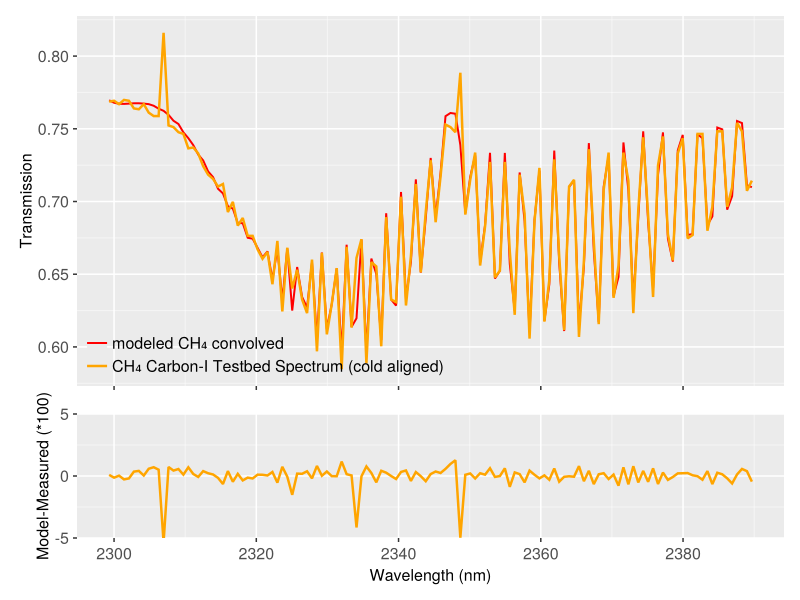

In [63]:
with_theme(plotFit, theme_ggplot2())

> Plot a subset of the range for all iterations (showing quick convergence)

---

Now we just try to run the fit over a smaller wavelength range, which should provide even better fits as the SRF might vary across the FPA a bit. The residuals are indeed quite a bit better in the strong methane feature at 2.2µm. 

In [56]:
# Run a smaller subset:
ind= 150:300
#n_iter = 8
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_ch4_cold[:,2]./maximum(testbed_ch4_cold[:,2])
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.-3];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.002*y).^2);

# run iterations
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end

(iter, "Fitted FWHM", x_all[5, iter]) = (3, "Fitted FWHM", 0.7051596826378407)
(iter, "Fitted FWHM", x_all[5, iter]) = (5, "Fitted FWHM", 0.7158518892031482)
(iter, "Fitted FWHM", x_all[5, iter]) = (7, "Fitted FWHM", 0.7156543776093464)


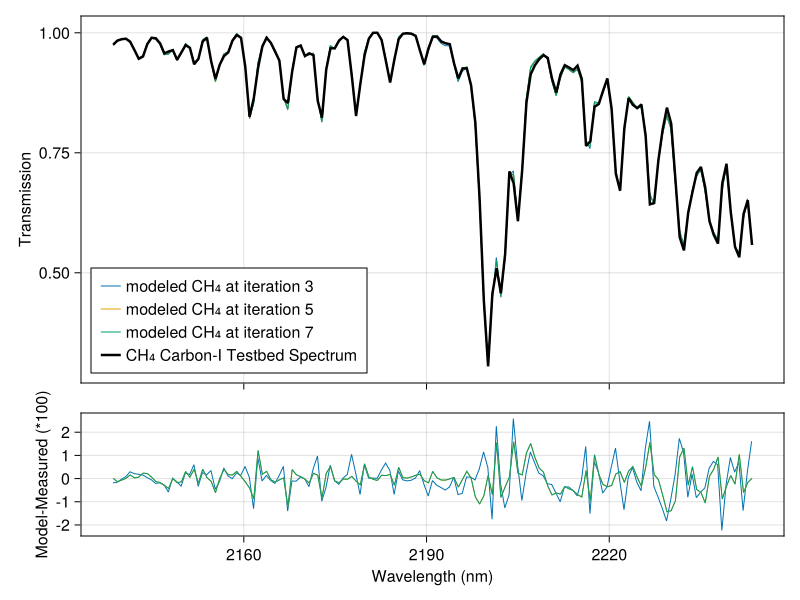

In [57]:
f = Figure(resolution = (800, 600))
ii = ind
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
rowsize!(f.layout, 2, Relative(0.25))
gridi = getGrid(x_all[:,end])
for iter = 3:2:n_iter
    @show iter, "Fitted FWHM", x_all[5,iter]
    y_fit = forward_model_testbed(x_all[:,iter])
    gridi = getGrid(x_all[:,iter])
    lines!(ax,  gridi, y_fit,  linewidth = 1.0, label = "modeled CH₄ at iteration $iter")
    lines!(ax2, gridi, (y_fit.-y)*100,  linewidth = 1., label = "Fit Residual at iteration $iter")
end
lines!(ax, gridi, y, color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum")
axislegend(ax,position = :lb)
ax.xticklabelsvisible = false
ax.xlabelvisible = false
#xlims!(ax, (2190, 2310))
#ylims!(ax, (0.75,1))
f

In [58]:
# Run a smaller subset:
ind= 300:500
#n_iter = 9
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_co_cold[:,2]./maximum(testbed_co_cold[:,2])
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.-3];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.002*y).^2);

# run iterations
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end


In [59]:
ind= 380:510
#n_iter = 6
# Switch CH4 to CO:
xs = xs_co
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_co_cold[:,2]./maximum(testbed_co_cold[:,2])
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.-3];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
x[4] = 1.5e20
# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.002*y).^2);

# run iterations
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end

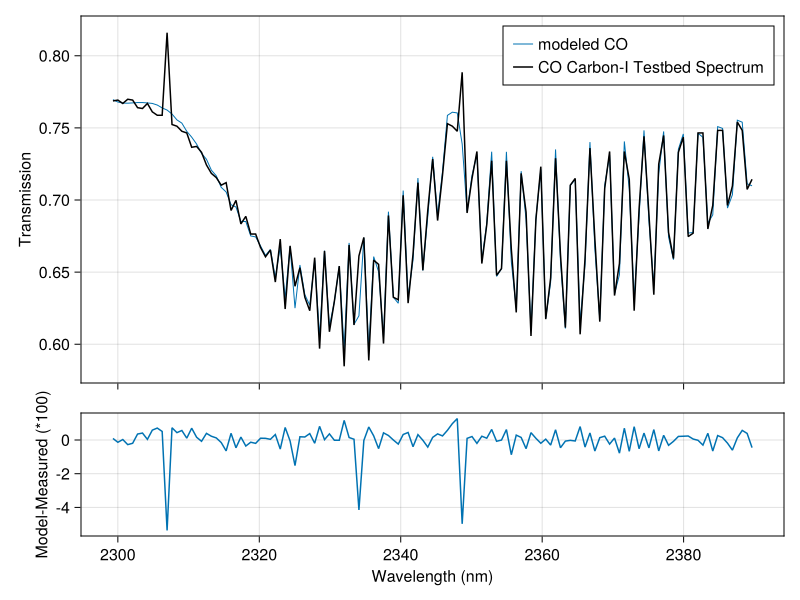

In [60]:
f = Figure(resolution = (800, 600))
ii = ind
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
rowsize!(f.layout, 2, Relative(0.25))
gridi = getGrid(x_all[:,end])
#for iter = 3:2:n_iter
#    @show iter, "Fitted FWHM", x_all[5,iter]
    y_fit = forward_model_testbed(x_all[:,end])
    #gridi = getGrid(x_all[:,iter])
    lines!(ax,  gridi, y_fit,  linewidth = 1.0, label = "modeled CO ")
    lines!(ax2, gridi, (y_fit.-y)*100,  linewidth = 1.5, label = "Fit Residual ")
#end
lines!(ax, gridi, y, color = :black, linewidth = 1.5, label = "CO Carbon-I Testbed Spectrum")
axislegend(ax,position = :rt)
ax.xticklabelsvisible = false
ax.xlabelvisible = false
#xlims!(ax, (2190, 2310))
#ylims!(ax, (0.75,1))
f

In [61]:
x_all[1:3,7]

3-element Vector{Float64}:
 2033.985266603829
    0.7005083856172896
   -6.026194277388318e-6